<p style="text-align: center;font-size: 24px;"><strong>UC Berkeley ML and AI Capstone Project</strong></p>
<p style="text-align: center;font-size: 20px;"><strong>Telcommunication Customer Churn Analysis and Prediction</strong></p>
<p style="text-align: right;font-size: 14px;">by Bowang Xiao, May 2025</p>
 

## OVERVIEW

This is to analyze and predict wheater the customer will stay in the program. Customers who left within the last month – the column is called Churn. 
Two objectives.
1) analyze which factor affect the churn score the most.
2) build a model to predict the churn score so that the company can do something to keep the customer.

## The data

https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download 

Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.datasets import load_digits

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score


import time
from joblib import parallel_backend

In [2]:
## loading the data
churn = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
digits, labels = load_digits(return_X_y=True)

In [3]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Data Preparation -- 1. Cleanup
After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn.

In [6]:
churn['TotalCharges'] = churn['TotalCharges'].replace(' ', np.nan).astype('float')
## removes all rows from the churn DataFrame that contain any missing (NaN) values. 
churn = churn.dropna()

## drop the customerID, which is not related to the churn score.
churn = churn.drop(columns='customerID')

churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

## Data Preparation -- 2. Remove Outliers


In [7]:
## Outliers analysis to identify anomalies in the dataset.
## After examin the sample data, we can see there are 3 numerical features.
churn[['SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges']].value_counts()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges
0              1       20.20           20.20           11
                       19.75           19.75            9
                       19.90           19.90            8
                       19.65           19.65            8
                       20.05           20.05            7
                                                       ..
               22      94.65           2104.55          1
                       93.20           2157.30          1
                       90.00           1993.80          1
                       89.40           2001.50          1
1              72      117.35          8436.25          1
Name: count, Length: 6814, dtype: int64

In [8]:
churn[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()
from scipy.stats import zscore

z_scores = churn[['tenure', 'MonthlyCharges', 'TotalCharges']].apply(zscore)
outliers = (abs(z_scores) > 3)

outlier_summary = outliers.sum()
print("Number of outliers by feature:\n", outlier_summary)

Number of outliers by feature:
 tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


In [9]:
def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR)))

outliers_iqr = churn[['tenure', 'MonthlyCharges', 'TotalCharges']].apply(detect_iqr_outliers)
print("Outliers detected (IQR method):")
print(outliers_iqr.sum())

Outliers detected (IQR method):
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


In [10]:
## split the data to train set and test set. set y=churn['Churn']
X_train, X_test, y_train, y_test = train_test_split(churn.drop(['Churn'], axis = 1), churn['Churn'], random_state = 442,
                                                   stratify = churn['Churn'])

## Data Preparation -- 3. transformation
- incorporate many of the categorical features
- Use the make_column_transformer function on the the columns selected by selector. To these columns, apply the OneHotEncoder with drop = first. To the remainder columns, apply StandardScaler()
- Feature Extractor

In [11]:
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())

## select the logistic Regression as a base model with a penalty to avoid overfitting.
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))


## Data Understanding and visulatilization

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

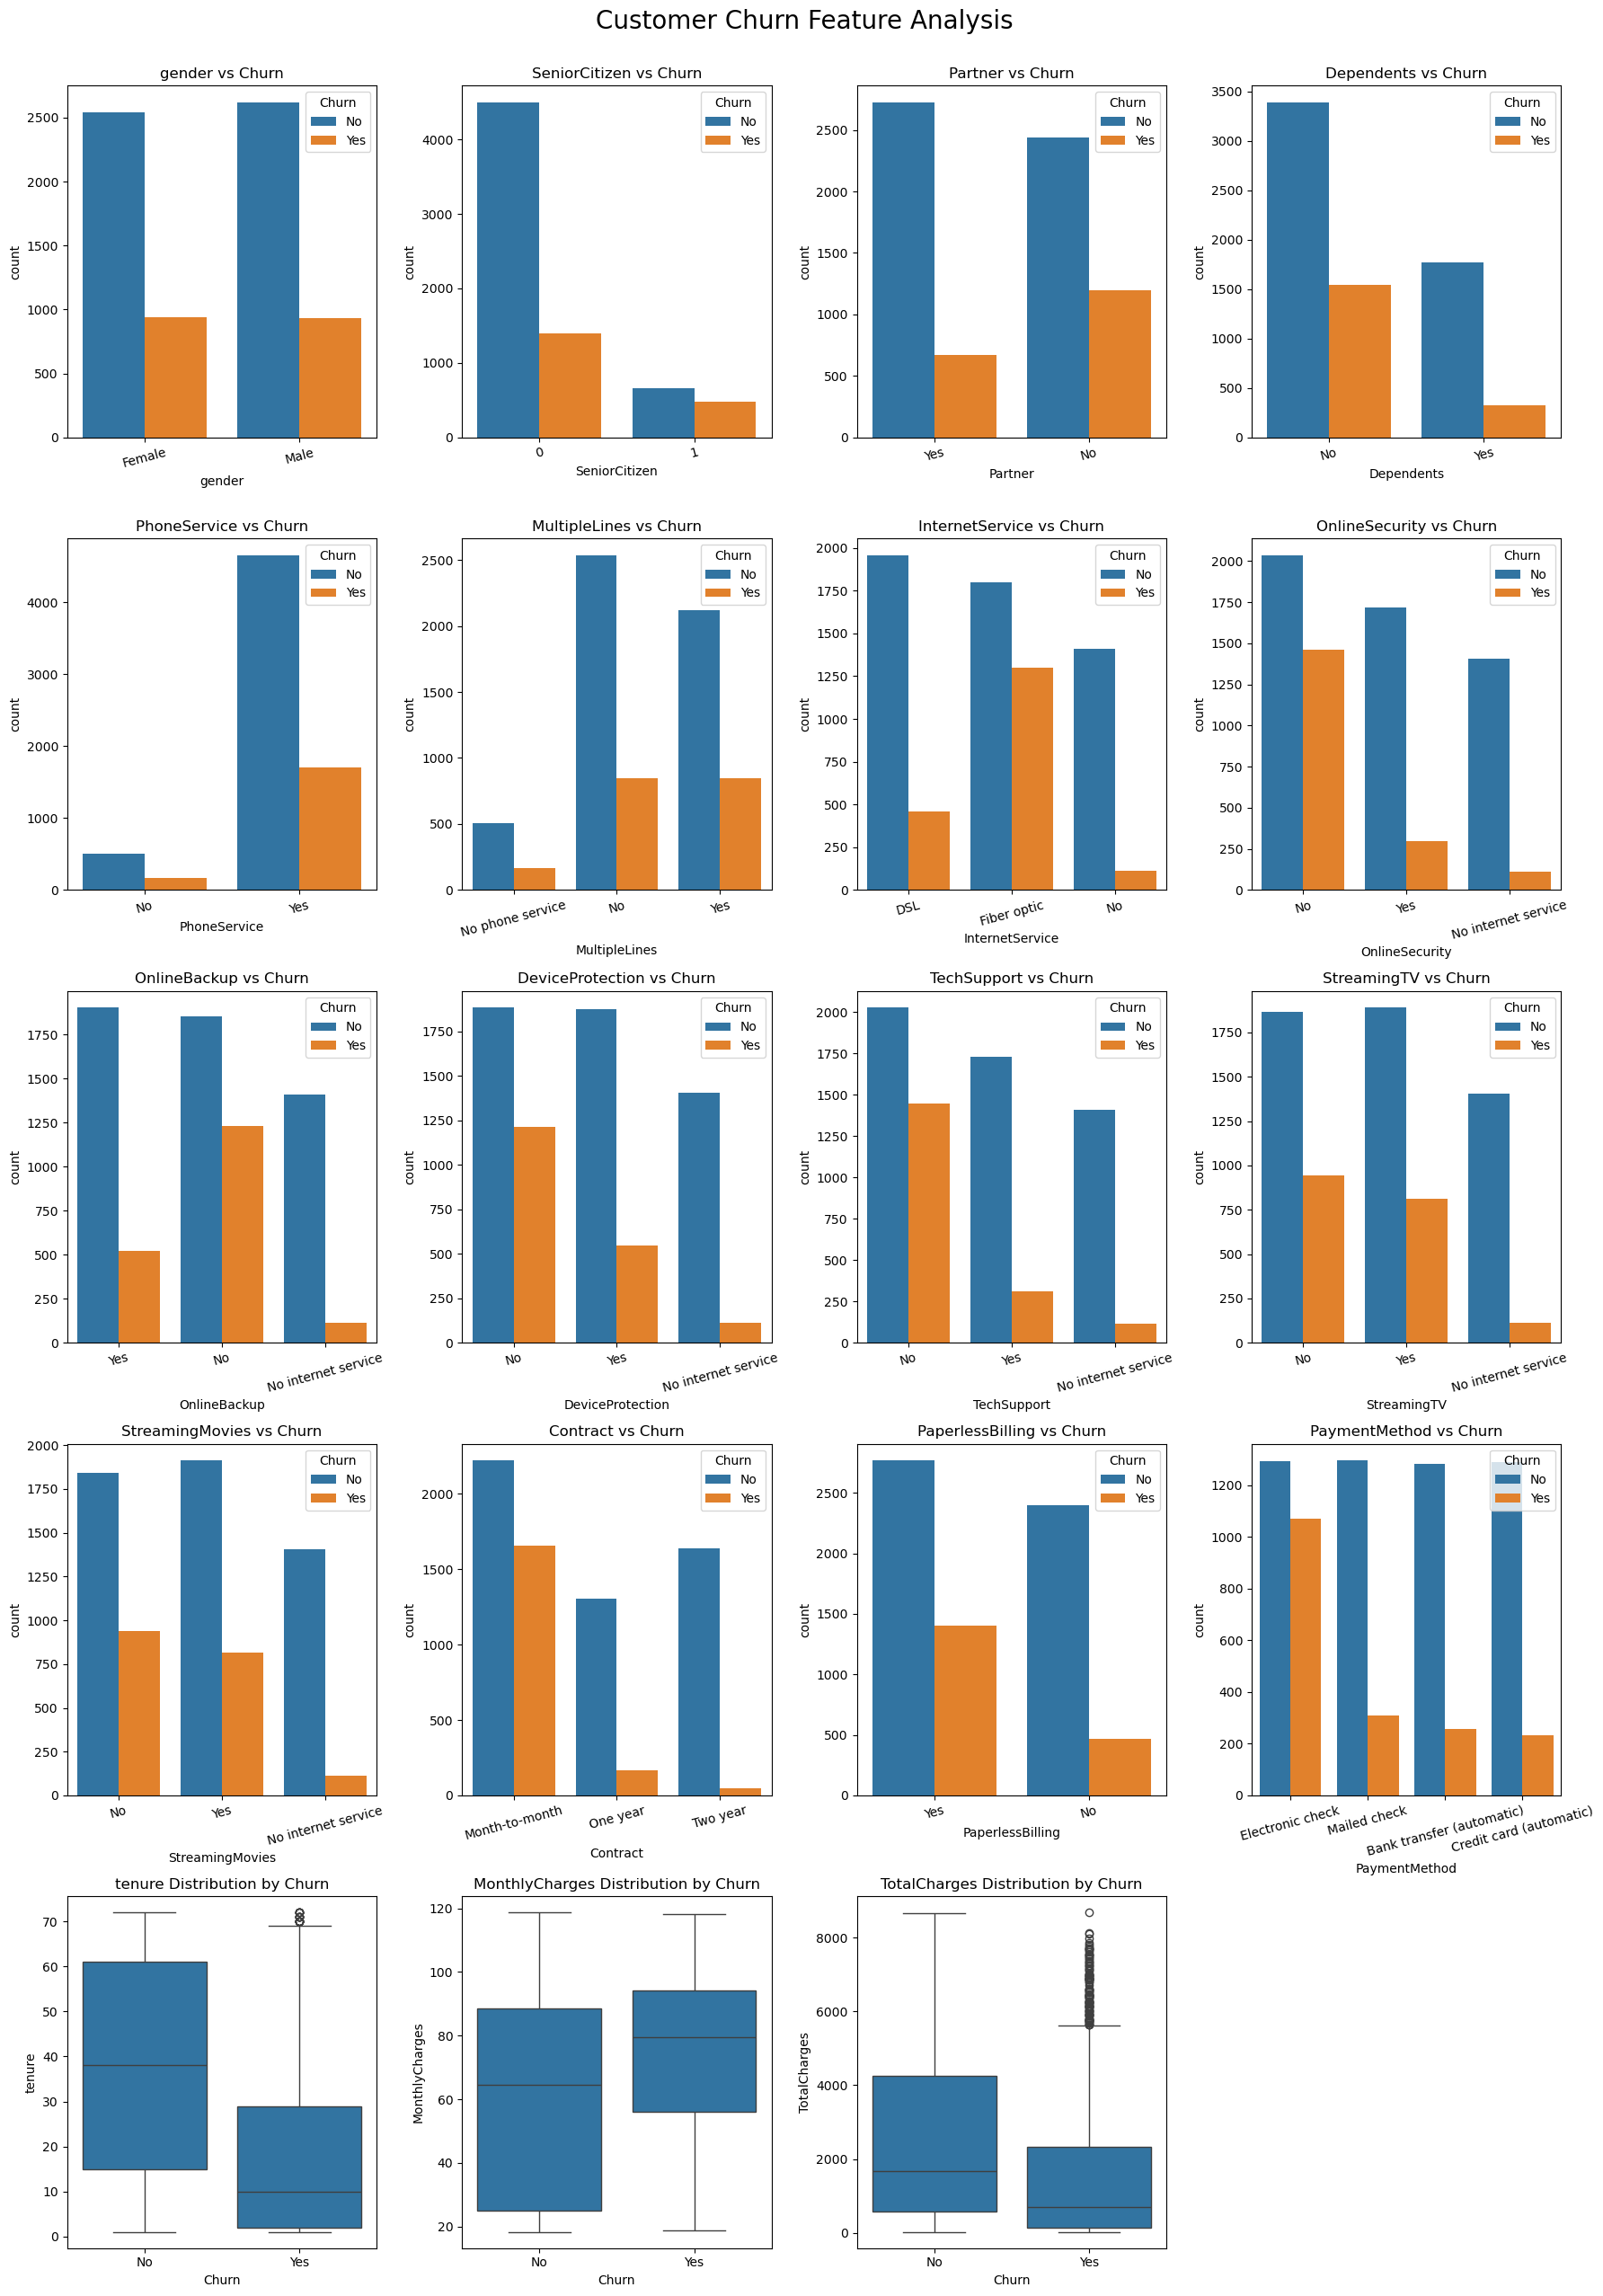

In [12]:
# Identify features
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Set up subplots: adjust rows and columns to fit all features
total_features = len(categorical_features) + len(numerical_features)
ncols = 4
nrows = (total_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

# Plot categorical features
for i, feature in enumerate(categorical_features):
    sns.countplot(data=churn, x=feature, hue='Churn', ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].legend(title='Churn')

# Plot numerical features
for j, feature in enumerate(numerical_features):
    sns.boxplot(data=churn, x='Churn', y=feature, ax=axes[len(categorical_features) + j])
    axes[len(categorical_features) + j].set_title(f'{feature} Distribution by Churn')

# Hide any unused subplots
for k in range(total_features, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.suptitle("Customer Churn Feature Analysis", fontsize=20, y=1.02)
plt.show()

Text(0, 0.5, 'Number of Customers')

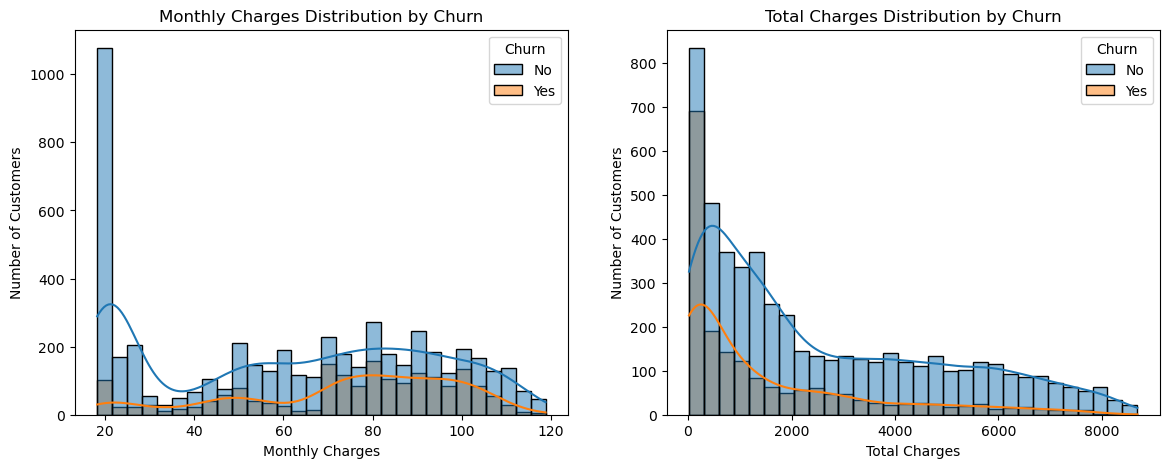

In [13]:
## Plot Churn VS. MonthlyCharges

# Set up the side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MonthlyCharges histogram
sns.histplot(data=churn, x='MonthlyCharges', hue='Churn', kde=True, bins=30, ax=axes[0])
axes[0].set_title("Monthly Charges Distribution by Churn")
axes[0].set_xlabel("Monthly Charges")
axes[0].set_ylabel("Number of Customers")

# TotalCharges histogram
sns.histplot(data=churn, x='TotalCharges', hue='Churn', kde=True, bins=30, ax=axes[1])
axes[1].set_title("Total Charges Distribution by Churn")
axes[1].set_xlabel("Total Charges")
axes[1].set_ylabel("Number of Customers")

## Intuitive impression from the above plots
#### these features do not affect the churn score much.
- SeniorCitizen
- Dependents
- InternetService
- Contract
- tenure
- MonthlyCharges

#### these features do not affect the churn score much.
- gender
- Partner
- StreamingMovies
- StreamingTV
- MultipleLines
- MultipleLines
- PaymentMethod
- DeviceProtection
#### these features do not affect the churn score much.
- PhoneService
- PaperlessBilling
- PaymentMethod


## Correlation Analysis


In [14]:
churn_encoded = pd.get_dummies(churn, drop_first=True)
churn_encoded.info()
churn_encoded.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   gender_Male                            7032 non-null   bool   
 5   Partner_Yes                            7032 non-null   bool   
 6   Dependents_Yes                         7032 non-null   bool   
 7   PhoneService_Yes                       7032 non-null   bool   
 8   MultipleLines_No phone service         7032 non-null   bool   
 9   MultipleLines_Yes                      7032 non-null   bool   
 10  InternetService_Fiber optic            7032 non-null   bool   
 11  InternetS

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
501,1,71,80.70,5676.00,False,True,False,True,False,True,...,False,False,False,False,True,True,True,False,False,False
1055,0,36,19.55,620.75,False,False,False,True,False,False,...,False,True,False,True,False,False,False,False,True,False
1579,1,12,80.45,950.20,True,True,False,True,False,False,...,False,False,True,False,False,True,False,True,False,True
3250,0,11,20.55,184.95,True,True,False,True,False,False,...,False,True,False,True,False,True,False,False,True,False
2382,0,29,39.50,1082.75,False,False,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False


In [15]:
# Calculate correlation matrix
correlation_matrix = churn_encoded.sample(1000).corr()

# Display the correlation of each feature with price
churn_correlation = correlation_matrix['Churn_Yes'].sort_values(ascending=False)
print(churn_correlation)

Churn_Yes                                1.000000
InternetService_Fiber optic              0.312445
PaymentMethod_Electronic check           0.278807
MonthlyCharges                           0.207835
PaperlessBilling_Yes                     0.172599
SeniorCitizen                            0.116540
StreamingMovies_Yes                      0.062299
MultipleLines_Yes                        0.051742
StreamingTV_Yes                          0.050216
PhoneService_Yes                         0.020684
MultipleLines_No phone service          -0.020684
DeviceProtection_Yes                    -0.021232
gender_Male                             -0.047851
OnlineBackup_Yes                        -0.063571
PaymentMethod_Credit card (automatic)   -0.100839
TechSupport_Yes                         -0.110789
Partner_Yes                             -0.114315
Contract_One year                       -0.115630
PaymentMethod_Mailed check              -0.124716
Dependents_Yes                          -0.144369


In [16]:
## from the correlation matirx, we can see most of the features impact the churn score 
## The below features are not affecting the churn score much.
# StreamingMovies_Yes                      0.020348
# StreamingTV_Yes                          0.006431
# PhoneService_Yes                         0.004655
# MultipleLines_No phone service          -0.004655
# MultipleLines_Yes                       -0.013502
# gender_Male                             -0.023184
# PaymentMethod_Mailed check              -0.073559
# DeviceProtection_Yes                    -0.077618

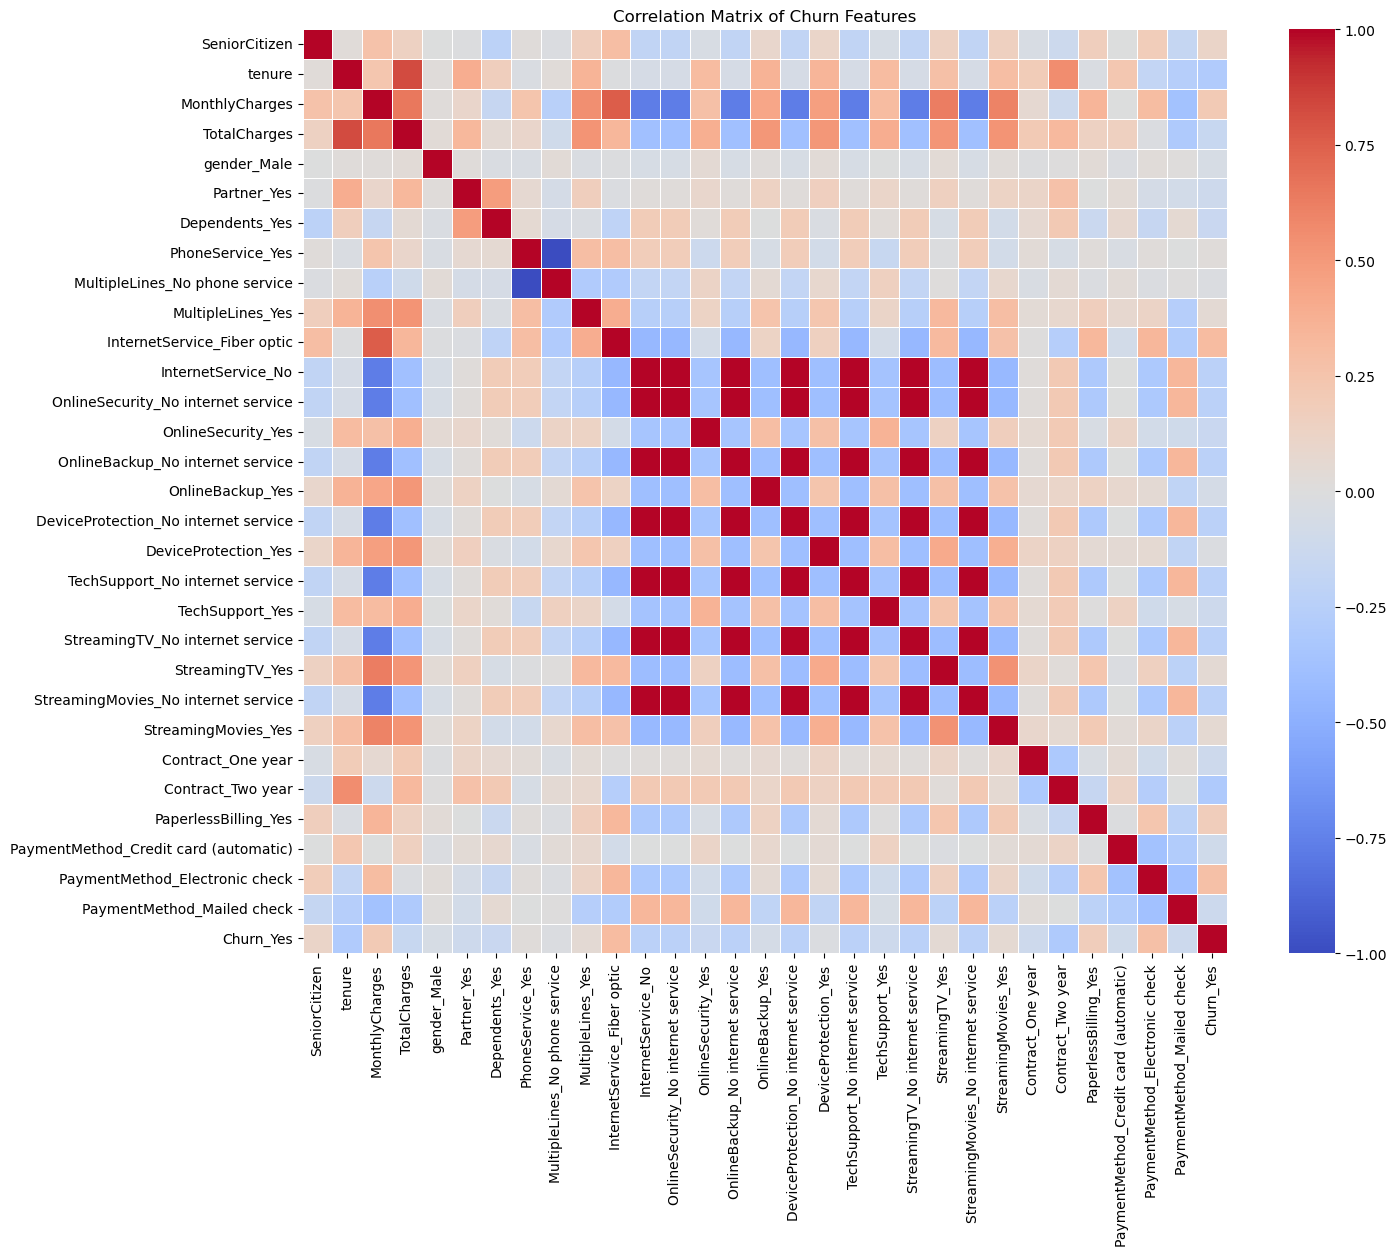

In [17]:
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Churn Features")
plt.show()

## Data analysis summary
While the intuitive analysis on the plots can give us some rough ideas of each feature's importance, the correlation analysis can give us numerical evaluation of each feature influence, either positive correlation (toward churn score 1), or negative correlation (toward churn score 0).

- In general, long tenure customers, 2 year contracts will stay longer with the program. 
- The customers without internet will stay longer, and on the opposite, the customers with fast fiber internet more likely to leave.
- when the monthly charges is below **\$60** , churn score is low, and then increases from **\$60** to **\$100**. and then decrease after \$100. It means the low income and high income will more likely stay.
- autopay will help keep the customers, and electronic check lead to high churn score. Surprisingly, the very traditional payment method, mailed check, lead to low churn score.
- paperbilling lead to higher churn score. The company should encourage electronic billing to keep the customers and also save mailing cost.

#### 📈 Features Associated with Higher Churn Risk

| Feature                            | Churn Impact Score |
|------------------------------------|---------------------|
| InternetService_Fiber optic        | +0.275044           |
| PaymentMethod_Electronic check     | +0.267562           |
| MonthlyCharges                     | +0.178816           |
| PaperlessBilling_Yes               | +0.175606           |
| SeniorCitizen                      | +0.169751           |

#### 📉 Features Associated with Lower Churn Risk (Customer Retention)

| Feature                              | Churn Impact Score |
|--------------------------------------|---------------------|
| Dependents_Yes                       | −0.183059           |
| TotalCharges                         | −0.205597           |
| StreamingTV_No internet service      | −0.212728           |
| StreamingMovies_No internet service  | −0.212728           |
| DeviceProtection_No internet service | −0.212728           |
| OnlineBackup_No internet service     | −0.212728           |
| OnlineSecurity_No internet service   | −0.212728           |
| InternetService_No                   | −0.212728           |
| TechSupport_No internet service      | −0.212728           |
| Contract_Two year                    | −0.282444           |
| tenure                               | −0.355997           |


## Modeling with a base model
With the final dataset in hand, lets build a model as the baseline. 

In [18]:
## build a pipeline for the data transformation and training.
LogisticRegression_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])



In [19]:
## print the pipeline structure

print(LogisticRegression_pipe)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FFBD833CB0>)])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])


In [20]:
## plot the pipeline structure
from sklearn import set_config
set_config(display='diagram')

LogisticRegression_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FFBD833CB0>)])),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'))),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

## The criteria to evaluate the model, confusion matrix

Train Accuracy: 0.8015
Test Accuracy:  0.8185


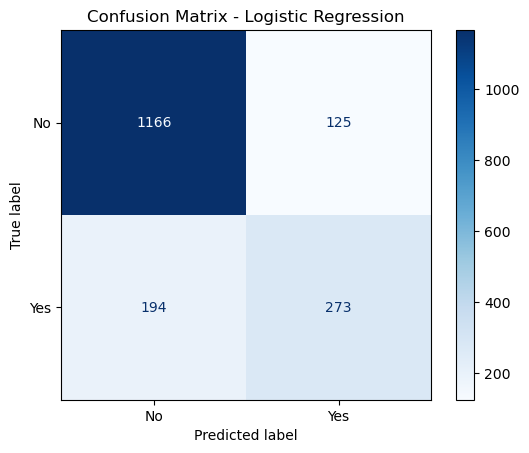

In [21]:
LogisticRegression_pipe.fit(X_train, y_train)

# Accuracy scores
train_acc = LogisticRegression_pipe.score(X_train, y_train)
test_acc = LogisticRegression_pipe.score(X_test, y_test)

# Print accuracies
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

# Predict on test set
y_pred = LogisticRegression_pipe.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LogisticRegression_pipe.classes_)

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [22]:
# Calculate recall for the positive class (e.g., 'Churn' = 'Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')  
print(f"Recall: {recall:.4f}")

Recall: 0.5846


## Initial Report and Exploratory Data Analysis (EDA)
- The features of the churn data set are anlayzed through the plots and correlation analysis. The tenure, contract length, internet service and monthly charges paly important roles in the churn score.
- The data is cleaned and transformed for ML models. A Logistic Regression model is used for the intial training and prediction as the baseline. Its accuracy is about 80%. 
- More models will be tuned with grid search and compared for the final report. We expect to develop a model with 95% and higher accuracy so that the telecommunication company can do some special promotions to keep the customers with high churn scores.
